In [1]:
# Initialization
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import hddm
import numpy as np
import pickle
from patsy import dmatrix
from kabuki.analyze import gelman_rubin
from kabuki.analyze import post_pred_gen
from kabuki.utils import concat_models
import pathlib

In [2]:
print (hddm.__version__)

1.0.1RC


In [3]:
data_F = hddm.load_csv('./HDDM_InconStim_6Frame.csv')

In [4]:
data_F.head(10)

,subj_idx,trial,rt,stim_frame,key_response,response,blockname,task,stim_file,HSF_emo,LSF_emo,congruence
0,114192,2,0.984893,6,e,1,BlockFvN,1,A,2,1,2
1,114192,6,0.926056,6,e,1,BlockFvN,1,B,1,2,2
2,114192,9,0.854008,6,e,1,BlockFvN,1,B,1,2,2
3,114192,11,0.881858,6,e,1,BlockFvN,1,B,1,2,2
4,114192,12,0.918875,6,e,1,BlockFvN,1,B,1,2,2
5,114192,13,0.906791,6,e,1,BlockFvN,1,B,1,2,2
6,114192,15,0.949124,6,f,0,BlockFvN,1,A,2,1,2
7,114192,16,0.839553,6,e,1,BlockFvN,1,A,2,1,2
8,114192,17,1.006603,6,f,0,BlockFvN,1,A,2,1,2
9,114192,24,0.855258,6,f,0,BlockFvN,1,A,2,1,2


In [5]:
data_F.tail(10)

,subj_idx,trial,rt,stim_frame,key_response,response,blockname,task,stim_file,HSF_emo,LSF_emo,congruence
9740,993849,330,0.601870,6,n,0,BlockF_1,2,B,1,2,2
9741,993849,331,0.681040,6,b,1,BlockF_1,2,A,2,1,2
9742,993849,332,0.599069,6,b,1,BlockF_1,2,B,1,2,2
9743,993849,334,0.551520,6,n,0,BlockF_1,2,A,2,1,2
9744,993849,336,0.538108,6,b,1,BlockF_1,2,B,1,2,2
9745,993849,339,0.776732,6,b,1,BlockF_1,2,A,2,1,2
9746,993849,341,0.503375,6,n,0,BlockF_1,2,A,2,1,2
9747,993849,343,0.515187,6,n,0,BlockF_1,2,B,1,2,2
9748,993849,344,0.614084,6,b,1,BlockF_1,2,A,2,1,2
9749,993849,349,0.615294,6,b,1,BlockF_1,2,B,1,2,2


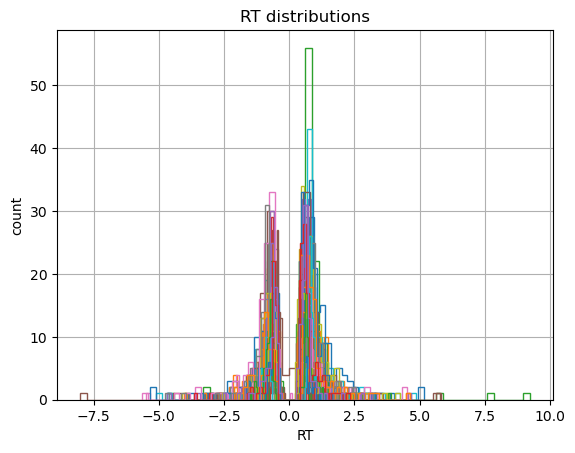

In [6]:
# Plot the RT distributions for the upper (+) and lower (-) bounds
# first flip the RT for the lower bound using flip error, i.e., the lower bound RT to make it negative
data_F = hddm.utils.flip_errors(data_F)
fig = plt.figure()
ax = fig.add_subplot(111, xlabel = 'RT', ylabel = 'count', title = 'RT distributions')
for i, subj_data in data_F.groupby('subj_idx'):
    subj_data.rt.hist(bins = 50, histtype = 'step', ax = ax)
    
plt.savefig('./testrt.pdf')


In [7]:
# instantiate model object (no need to call flip_errors() before passing it).
# tailoring an individual hierarchical DDM around dataset.
dependancies = {'v':['HSF_emo'],'a':['task']}
m4 = hddm.HDDM(data_F, include=('z', 'v', 'a', 't'), depends_on = dependancies, p_outlier = 0.05, informative = False)
# find good starting point. helps with convergence
m4.find_starting_values()
# start drawing 5000 samples and discarding 2500 as burn-in, every 2nd thinned
m4.sample(5000, burn=2500, thin = 2, dbname = './m4_traces.db', db = 'pickle')

No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 5001 of 5000 complete in 2308.5 sechddm sampling elpased time:  2308.775 s


In [8]:
m4.save('./m4_traces')

In [9]:
stats = m4.gen_stats()
m4.print_stats()

                      mean       std      2.5q       25q       50q       75q     97.5q    mc err
a(1)              1.338844   0.03334  1.273377  1.315506  1.337668  1.360275  1.407694  0.001046
a(2)              1.314538  0.033987   1.25035  1.292976  1.314644  1.336856  1.380357  0.001124
a(3)              1.372036  0.033359  1.306243   1.34986  1.371544  1.394304  1.440269  0.000944
a_std             0.248876   0.01548  0.219881  0.238154  0.248585  0.258908  0.280679  0.000656
a_subj(1).114192  1.240581  0.088016  1.071038  1.180328  1.234378  1.300117  1.418318   0.00287
a_subj(2).114192  1.270293  0.087783  1.105768  1.208952   1.26863  1.329839  1.447606  0.002731
a_subj(3).114192  1.657236  0.102736  1.463038  1.587956  1.658301  1.721721  1.869397  0.003032
a_subj(1).136867  1.468732  0.088981  1.293741  1.411105  1.467684  1.529633  1.635558  0.002538
a_subj(2).136867  1.214956  0.082385  1.064637   1.15733  1.211171  1.269614  1.379821  0.002385
a_subj(3).136867  1.334462  0.

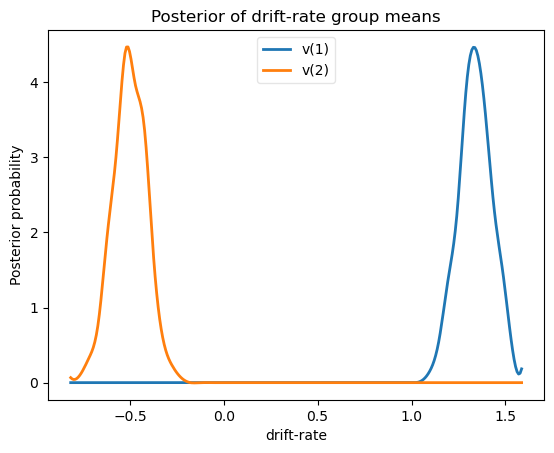

In [10]:
v_1, v_2 = m4.nodes_db.node[['v(1)','v(2)']]
hddm.analyze.plot_posterior_nodes([v_1,v_2])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
plt.savefig('./m4dr.pdf', bbox_inches ="tight")

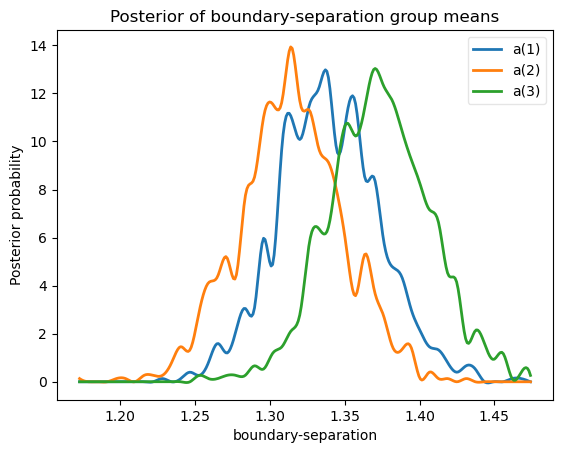

In [11]:
a_1, a_2, a_3 = m4.nodes_db.node[['a(1)','a(2)','a(3)']]
hddm.analyze.plot_posterior_nodes([a_1, a_2, a_3])
plt.xlabel('boundary-separation')
plt.ylabel('Posterior probability')
plt.title('Posterior of boundary-separation group means')
plt.savefig('./m4bs.pdf', bbox_inches ="tight")

In [12]:
print ("P(v(1) > v(2)) = ", (v_1.trace() > v_2.trace()).mean())
print ("P(v(2) > v(1)) = ", (v_2.trace() > v_1.trace()).mean())

P(v(1) > v(2)) =  1.0
P(v(2) > v(1)) =  0.0


In [13]:
print ("P(a(1) > a(2)) = ", (a_1.trace() > a_2.trace()).mean())
print ("P(a(2) > a(1)) = ", (a_2.trace() > a_1.trace()).mean())
print ("P(a(1) > a(3)) = ", (a_1.trace() > a_3.trace()).mean())
print ("P(a(3) > a(1)) = ", (a_3.trace() > a_1.trace()).mean())
print ("P(a(2) > a(3)) = ", (a_2.trace() > a_3.trace()).mean())
print ("P(a(3) > a(2)) = ", (a_3.trace() > a_2.trace()).mean())

P(a(1) > a(2)) =  0.7
P(a(2) > a(1)) =  0.3
P(a(1) > a(3)) =  0.2344
P(a(3) > a(1)) =  0.7656
P(a(2) > a(3)) =  0.1136
P(a(3) > a(2)) =  0.8864
